# Number recognition

## Model generation

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import SVG

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

In [2]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

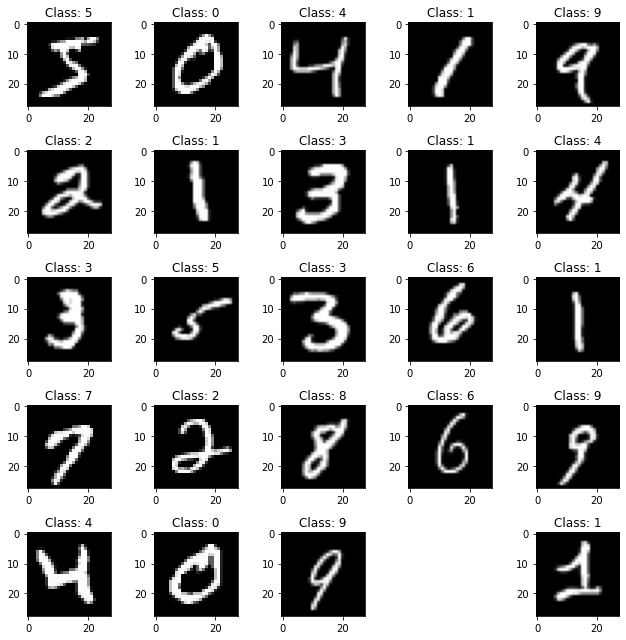

In [3]:
plt.figure(figsize=(9,9))
for idx in range(25):
  plt.subplot(5,5, idx+1)
  plt.imshow(X_train[idx], cmap='gray')
  plt.title('Class: {}'.format(Y_train[idx]))

  plt.tight_layout()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

X_train = X_train.reshape(-1, img_rows, img_cols, 1)
X_test = X_test.reshape(-1, img_rows, img_cols, 1)

In [6]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [7]:
if np.max(X_train) >1: X_train = X_train / 255
if np.max(X_test) >1: X_test = X_test / 255

In [8]:
if len(Y_train.shape)==1:
  num_classes = len(set(Y_train))
  Y_train = to_categorical(Y_train, num_classes)
  Y_test = to_categorical(Y_test, num_classes)

Y_train.shape

(60000, 10)

In [25]:
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(512, input_shape=(784, )),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3)),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

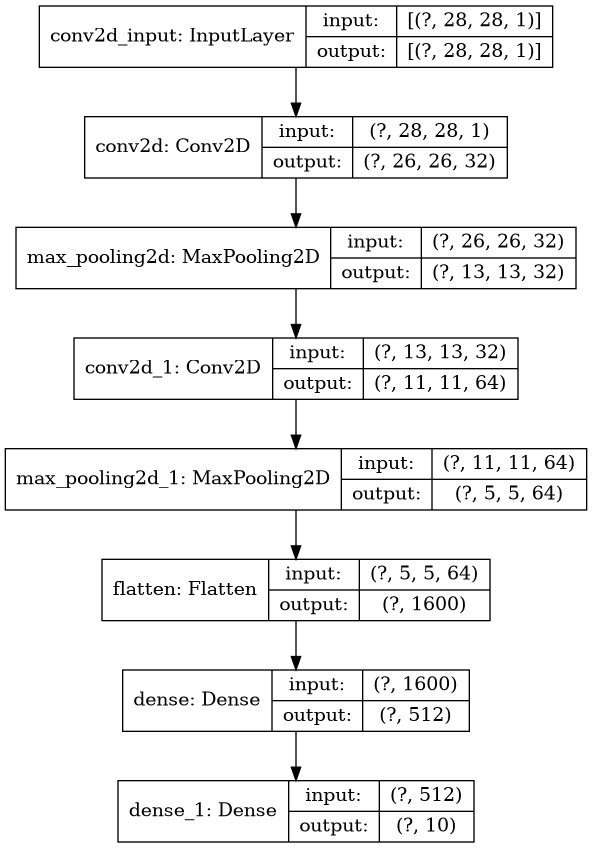

In [10]:
plot_model(model, to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
dpi=96
)

In [12]:
tensorboard_callback = TensorBoard(log_dir='./logs/TensorBoard1', histogram_freq=1)

In [13]:
model.fit(
  X_train, Y_train,
  batch_size=128,
  epochs=20,
  verbose=2,
  validation_data=(X_test,Y_test),
  callbacks=[tensorboard_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 - 39s - loss: 0.1662 - accuracy: 0.9508 - val_loss: 0.0499 - val_accuracy: 0.9851
Epoch 2/20
60000/60000 - 39s - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 3/20
60000/60000 - 36s - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.0315 - val_accuracy: 0.9900
Epoch 4/20
60000/60000 - 31s - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0381 - val_accuracy: 0.9880
Epoch 5/20
60000/60000 - 30s - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.0376 - val_accuracy: 0.9891
Epoch 6/20
60000/60000 - 29s - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.0361 - val_accuracy: 0.9903
Epoch 7/20
60000/60000 - 30s - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0340 - val_accuracy: 0.9915
Epoch 8/20
60000/60000 - 30s - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0486 - val_accuracy: 0.9890
Epoch 9/20
60000/60000 - 34s - loss: 0.0092 - accuracy: 0.9969 - val_loss: 0.0446 - val_accuracy: 0.9902
Epoch

In [14]:
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.058329494212957626, 0.9893]

In [11]:
%tensorboard --logdir './logs/TensorBoard'

In [15]:
model.save('number_recognition_model_conv.h5')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
________________________________________________

## Data testing

In [33]:
from PIL import Image
from math import floor, ceil
from matplotlib import cm

In [34]:
def predict(img):
  global model
  res = model.predict([img])[0]
  return np.argmax(res), max(res)

def process_img(path_to_img):
  image = Image.open(path_to_img)
  image = image.convert('L')
  image = np.array(image)
  image = image / 255
  new_image = np.zeros((28, 28))
  old_image_rows, old_image_cols = image.shape
  new_image[14- floor(old_image_rows/2):14 + ceil(old_image_rows/2), 14- floor(old_image_cols/2):14 + ceil(old_image_cols/2)] = image
  new_image = new_image.reshape(1, 28, 28, 1)
  new_image[new_image<0.1] = 0
  return new_image

In [35]:
predict(process_img("digits_for_testing/2.png"))

(2, 0.9997557)

## Model explaining

In [36]:
import shap
import numpy as np


In [37]:
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]
background = background.reshape(50, 28, 28, 1)
background.shape

(50, 28, 28, 1)

In [38]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



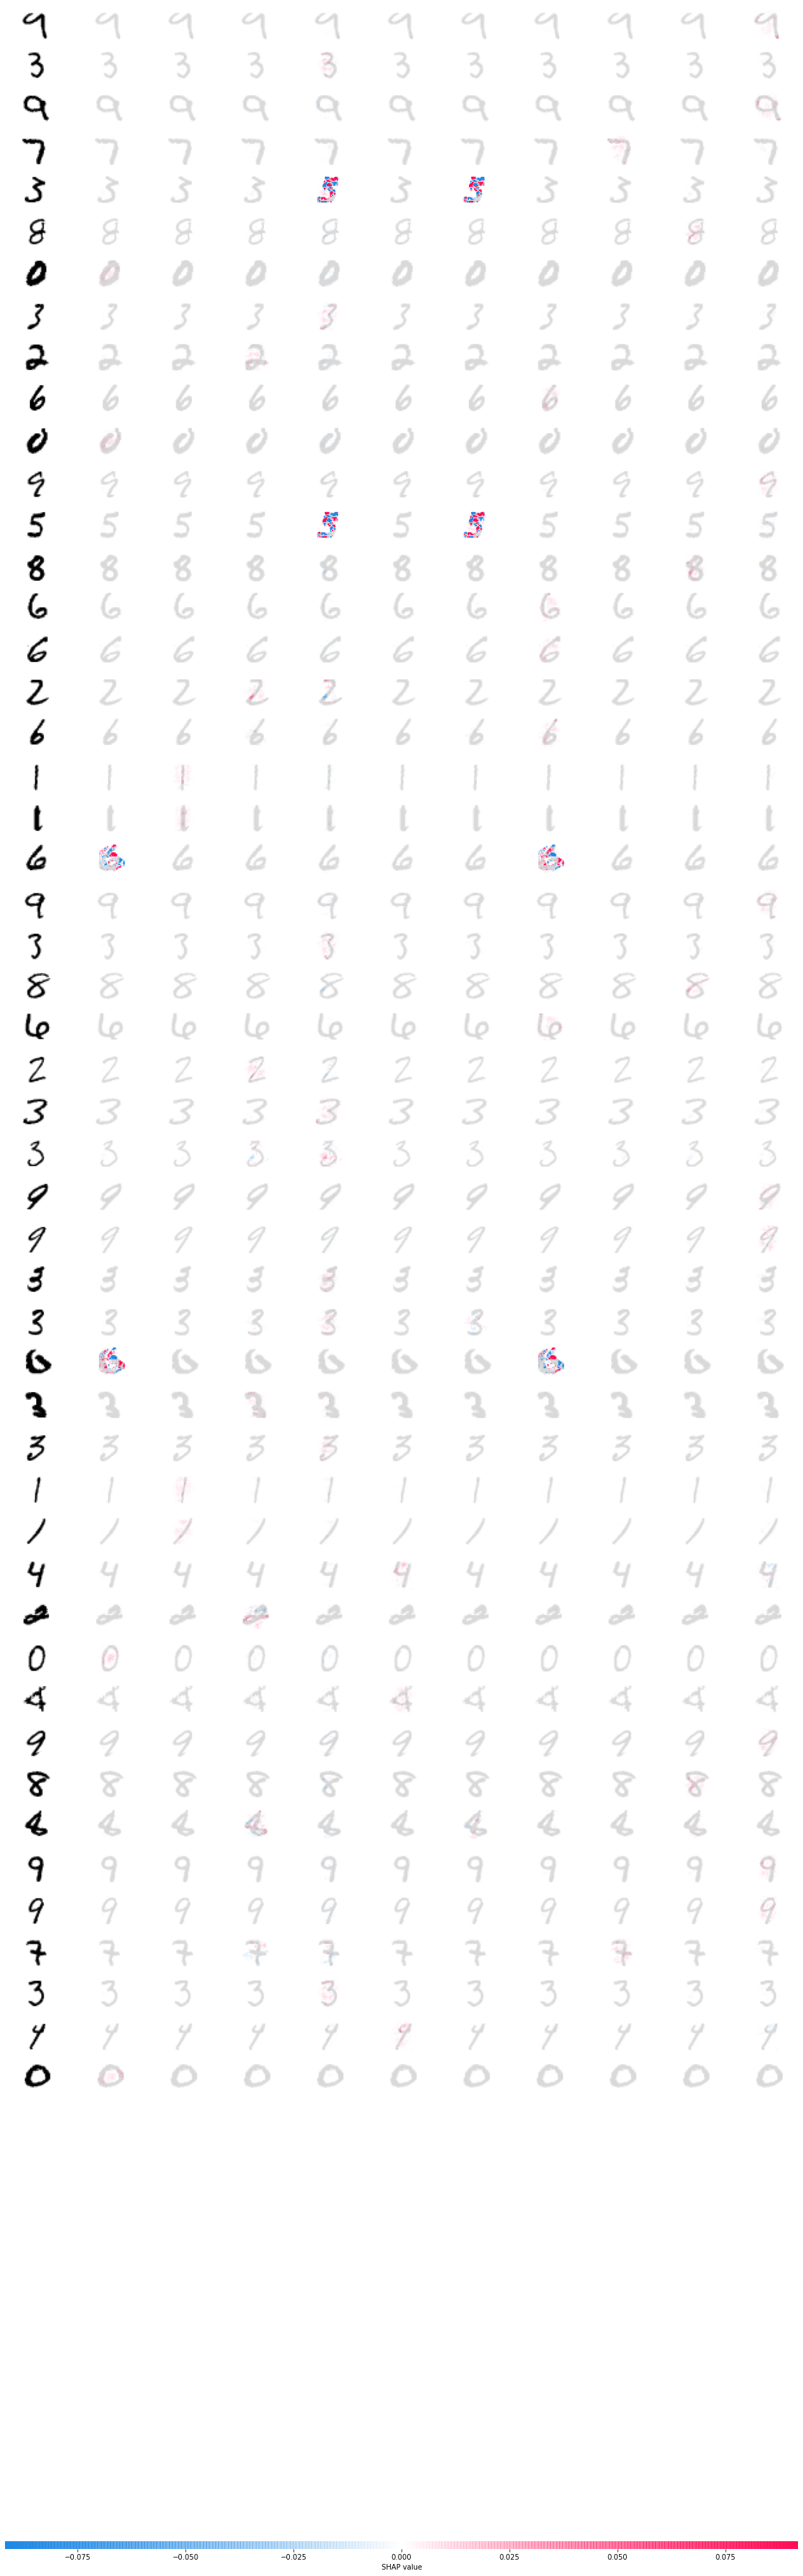

In [39]:
shap.image_plot(shap_values, -background, show=False)
plt.savefig("shap.png")